In [120]:
from dataclasses import dataclass

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
fhandler = logging.FileHandler(filename='simulate.log', mode='w')
formatter = logging.Formatter('%(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

@dataclass
class Entity:
    id: int
    arrival_time: float
    interarrival_time: float
    service_time: float
    def __repr__(self):
        return f"Entity(\
id={self.id}, \
arrival_time={self.arrival_time}, \
interarrival_time={self.interarrival_time}, \
service_time={self.service_time})"

class FIFO_queue:
    def __init__(self, q_type, entity_list=None):
        self.q_type = q_type
        if entity_list:
            self.queue = entity_list
        else:
            self.queue = []
    def add(self, entity, clock):
        logger.info(f"[{clock}][{self.q_type} queue]: ADD {entity}")
        self.queue.insert(0, entity)
    def pop(self, clock):
        pop_entity = self.queue.pop()
        logger.info(f"[{clock}][{self.q_type} queue]: POP {pop_entity}")
        return pop_entity
    def __repr__(self):
        return f"FIFO_queue({self.queue})"

class Server:
    def __init__(self, shotdown_policy = False):
        self.shotdown_policy = shotdown_policy
        self.shotdown = False
        # self.busy_until = 0
        self.entity = None
    
    def check_shotdown(self, clock = None):
        if self.shotdown_policy == True:
            if clock != None:
                location_in_period = clock % (400 + 400 + 2000)
                if 400 <= location_in_period and location_in_period < (400 + 400):
                    if self.shotdown == False:
                        logger.info(f"[{clock}][Server]: SHOTDOWN, {self.entity} in server")
                    self.shotdown = True
                else:
                    if self.shotdown == True:
                        logger.info(f"[{clock}][Server]: BACK, {self.entity} in server")
                    self.shotdown = False   
    def __repr__(self):
        return f"Server({self.entity})"

In [121]:
@dataclass
class Status:
    clock: int

    server: Server
    arriving_queue: FIFO_queue
    waiting_queue: FIFO_queue
    finished_queue: FIFO_queue

    B_t: list
    Q_t: list
    num_completed_waiting: int
    total_waiting_time_in_queue: list
    
    # area_under_Q_t: int
    # area_under_B_t: int

    unit_in_second: float
    second_pre_unit: int


    def check_Q_t(self):
        self.Q_t.append((self.clock, len(self.waiting_queue.queue)))
        # self.area_under_Q_t += len(self.waiting_queue.queue) * int(self.unit_in_second * self.second_pre_unit)

    def check_arrival(self):
        if self.arriving_queue.queue:
            len_arriving_queue = len(self.arriving_queue.queue)
            # logger.debug(f"check_arrival: {self.clock}, len of arriving_queue: {len_arriving_queue}")
            if self.clock == self.arriving_queue.queue[-1].arrival_time:
                # logger.info(f"[new_arrival]: clock {self.clock}")
                entity = self.arriving_queue.pop(self.clock)
                self.waiting_queue.add(entity, self.clock)

    
    def check_service(self):
        # logger.debug(f"check_service: {self.clock}, server: {self.server}")
        self.server.check_shotdown(self.clock)

        if self.server.entity != None:
            if self.server.shotdown == False:
            # if True:
                self.server.entity.service_time -= int(self.unit_in_second * self.second_pre_unit)
            
            if self.server.entity.service_time == 0: #! Check this
                self.finished_queue.add(self.server.entity, self.clock)
                logger.info(f"[{self.clock}][server]: FINISH {self.server.entity}")
                self.server.entity = None
                # logger.info(f"server: SERVE {self.server.entity}")
        if self.server.entity == None:
            if len(self.waiting_queue.queue) > 0:
                entity = self.waiting_queue.pop(self.clock)
                self.num_completed_waiting += 1
                self.server.entity = entity
                #! self.server.entity.service_time -= int(self.unit_in_second * self.second_pre_unit)
                #! self.total_waiting_time_in_queue += self.clock - entity.arrival_time
                if len(self.total_waiting_time_in_queue) > 0:
                    self.total_waiting_time_in_queue.append((self.clock, self.clock - entity.arrival_time + self.total_waiting_time_in_queue[-1][1])) #! Check this
                else:
                    self.total_waiting_time_in_queue.append((self.clock, self.clock - entity.arrival_time))
                logger.info(f"[{self.clock}][server]: START {self.server.entity}")
        
        server_status = 1 if self.server.entity else 0
        self.B_t.append((self.clock, server_status))
    
    def process(self):
        self.check_arrival()
        self.check_service()
        self.check_Q_t()
        self.clock += int(self.unit_in_second * self.second_pre_unit)
    
    def average_waiting_time_in_queue(self):
        return (self.total_waiting_time_in_queue[-1][1] / self.num_completed_waiting) * self.unit_in_second

    def time_average_number_in_queue(self):
        area_under_Q_t = sum([i[1] for i in self.Q_t[:-1]]) 
        # print(f"area under Q_t: {area_under_Q_t}")
        return area_under_Q_t / (len(self.Q_t[:-1])) #! Check this

    def utilization(self):
        area_under_B_t = sum([i[1] for i in self.B_t[:-1]])
        # print(f"area under B_t: {area_under_B_t}")
        return area_under_B_t / (len(self.B_t[:-1])) #1 Check this
        
    def __repr__(self):
        return f"===========\n\
clock: {self.clock}\n\n\
server: {self.server}\n\n\
arriving_queue: {self.arriving_queue}\n\n\
waiting_queue: {self.waiting_queue}\n\n\
finished_queue: {self.finished_queue}\n\n\
num_completed_waiting: {self.num_completed_waiting}\n\n\
total_waiting_time_in_queue: {self.total_waiting_time_in_queue}\n\
===========\n"
# B_t: {self.B_t}, Q_t: {self.Q_t}, 
    # def __repr__(self):
    #     return f"Status(\
# area_under_Q_t: {self.area_under_Q_t}, area_under_B_t: {self.area_under_B_t}\n\n\

In [122]:
arrival_time_list = [0, 173, 308, 379, 441, 1869, 1939, 3491, 3806, 3982]
interarrival_time_list = [173, 135, 71, 62, 1428, 70, 1552, 315, 176, 1]
service_time = [290, 176, 339, 452, 446, 436, 207, 336, 237, 538]

# arrival_time_list = [int(i*100) for i in arrival_time_list]
# interarrival_time_list = [int(i*100) for i in interarrival_time_list]
# service_time = [int(i*100) for i in service_time]

entity_list = [Entity(i + 1, arrival_time, interarrival_time, service_time) for i, (arrival_time, interarrival_time, service_time) in enumerate(zip(arrival_time_list, interarrival_time_list, service_time))]
entity_list.reverse()

system_status = Status(
    clock = int(0.00*100),
    server = Server(),
    arriving_queue = FIFO_queue("arring", entity_list.copy()),
    waiting_queue = FIFO_queue("waiting", None),
    finished_queue = FIFO_queue("finished", None),
    num_completed_waiting = 0,
    B_t = [], # Server status (time, status)
    Q_t = [], # Queue status (time, num_in_queue)
    total_waiting_time_in_queue = [],
    unit_in_second = 0.01,
    second_pre_unit = 100,
)
print(system_status)
while system_status.clock <= int(20.00*100):
   system_status.process()

print(system_status)

print(f"average waiting time in queue: {system_status.average_waiting_time_in_queue()}")
print(f"time average number in queue: {system_status.time_average_number_in_queue()}")
print(f"utilization: {system_status.utilization()}")

logger.info(f"average waiting time in queue: {system_status.average_waiting_time_in_queue()}")
logger.info(f"time average number in queue: {system_status.time_average_number_in_queue()}")
logger.info(f"utilization: {system_status.utilization()}")

# while system_status.clock <= int(1.73*100):
#    system_status.process()
#    if system_status.clock == int(1.73*100):
#       print(system_status)
#    system_status.clock += int(system_status.unit_in_second * system_status.second_pre_unit)


INFO:__main__:[0][arring queue]: POP Entity(id=1, arrival_time=0, interarrival_time=173, service_time=290)
INFO:__main__:[0][waiting queue]: ADD Entity(id=1, arrival_time=0, interarrival_time=173, service_time=290)
INFO:__main__:[0][waiting queue]: POP Entity(id=1, arrival_time=0, interarrival_time=173, service_time=290)
INFO:__main__:[0][server]: START Entity(id=1, arrival_time=0, interarrival_time=173, service_time=290)
INFO:__main__:[173][arring queue]: POP Entity(id=2, arrival_time=173, interarrival_time=135, service_time=176)
INFO:__main__:[173][waiting queue]: ADD Entity(id=2, arrival_time=173, interarrival_time=135, service_time=176)
INFO:__main__:[290][finished queue]: ADD Entity(id=1, arrival_time=0, interarrival_time=173, service_time=0)
INFO:__main__:[290][server]: FINISH Entity(id=1, arrival_time=0, interarrival_time=173, service_time=0)
INFO:__main__:[290][waiting queue]: POP Entity(id=2, arrival_time=173, interarrival_time=135, service_time=176)
INFO:__main__:[290][server

clock: 0

server: Server(None)

arriving_queue: FIFO_queue([Entity(id=10, arrival_time=3982, interarrival_time=1, service_time=538), Entity(id=9, arrival_time=3806, interarrival_time=176, service_time=237), Entity(id=8, arrival_time=3491, interarrival_time=315, service_time=336), Entity(id=7, arrival_time=1939, interarrival_time=1552, service_time=207), Entity(id=6, arrival_time=1869, interarrival_time=70, service_time=436), Entity(id=5, arrival_time=441, interarrival_time=1428, service_time=446), Entity(id=4, arrival_time=379, interarrival_time=62, service_time=452), Entity(id=3, arrival_time=308, interarrival_time=71, service_time=339), Entity(id=2, arrival_time=173, interarrival_time=135, service_time=176), Entity(id=1, arrival_time=0, interarrival_time=173, service_time=290)])

waiting_queue: FIFO_queue([])

finished_queue: FIFO_queue([])

num_completed_waiting: 0

total_waiting_time_in_queue: []

clock: 2001

server: Server(Entity(id=6, arrival_time=1869, interarrival_time=70, ser

In [123]:
arrival_time_list = [0, 173, 308, 379, 441, 1869, 1939, 3491, 3806, 3982]
interarrival_time_list = [173, 135, 71, 62, 1428, 70, 1552, 315, 176, 1]
service_time = [290, 176, 339, 452, 446, 436, 207, 336, 237, 538]

entity_list = [Entity(i + 1, arrival_time, interarrival_time, service_time) for i, (arrival_time, interarrival_time, service_time) in enumerate(zip(arrival_time_list, interarrival_time_list, service_time))]
entity_list.reverse()

system_status2 = Status(
    clock = int(0.00*100),
    server = Server(shotdown_policy=True),
    arriving_queue = FIFO_queue("arring", entity_list.copy()),
    waiting_queue = FIFO_queue("waiting", None),
    finished_queue = FIFO_queue("finished", None),
    num_completed_waiting = 0,
    B_t = [], # Server status (time, status)
    Q_t = [], # Queue status (time, num_in_queue)
    total_waiting_time_in_queue = [],
    unit_in_second = 0.01,
    second_pre_unit = 100,
)
print(system_status2)
while system_status2.clock <= int(20.00*100):
    system_status2.process()
    # if system_status.server.shotdown == True:
    #   print(system_status)
    #   break

print(system_status2)

print(f"average waiting time in queue: {system_status2.average_waiting_time_in_queue()}")
print(f"time average number in queue: {system_status2.time_average_number_in_queue()}")
print(f"utilization: {system_status2.utilization()}")

logger.info(f"average waiting time in queue: {system_status2.average_waiting_time_in_queue()}")
logger.info(f"time average number in queue: {system_status2.time_average_number_in_queue()}")
logger.info(f"utilization: {system_status2.utilization()}")

INFO:__main__:[0][arring queue]: POP Entity(id=1, arrival_time=0, interarrival_time=173, service_time=290)
INFO:__main__:[0][waiting queue]: ADD Entity(id=1, arrival_time=0, interarrival_time=173, service_time=290)
INFO:__main__:[0][waiting queue]: POP Entity(id=1, arrival_time=0, interarrival_time=173, service_time=290)
INFO:__main__:[0][server]: START Entity(id=1, arrival_time=0, interarrival_time=173, service_time=290)
INFO:__main__:[173][arring queue]: POP Entity(id=2, arrival_time=173, interarrival_time=135, service_time=176)
INFO:__main__:[173][waiting queue]: ADD Entity(id=2, arrival_time=173, interarrival_time=135, service_time=176)
INFO:__main__:[290][finished queue]: ADD Entity(id=1, arrival_time=0, interarrival_time=173, service_time=0)
INFO:__main__:[290][server]: FINISH Entity(id=1, arrival_time=0, interarrival_time=173, service_time=0)
INFO:__main__:[290][waiting queue]: POP Entity(id=2, arrival_time=173, interarrival_time=135, service_time=176)
INFO:__main__:[290][server

clock: 0

server: Server(None)

arriving_queue: FIFO_queue([Entity(id=10, arrival_time=3982, interarrival_time=1, service_time=538), Entity(id=9, arrival_time=3806, interarrival_time=176, service_time=237), Entity(id=8, arrival_time=3491, interarrival_time=315, service_time=336), Entity(id=7, arrival_time=1939, interarrival_time=1552, service_time=207), Entity(id=6, arrival_time=1869, interarrival_time=70, service_time=436), Entity(id=5, arrival_time=441, interarrival_time=1428, service_time=446), Entity(id=4, arrival_time=379, interarrival_time=62, service_time=452), Entity(id=3, arrival_time=308, interarrival_time=71, service_time=339), Entity(id=2, arrival_time=173, interarrival_time=135, service_time=176), Entity(id=1, arrival_time=0, interarrival_time=173, service_time=290)])

waiting_queue: FIFO_queue([])

finished_queue: FIFO_queue([])

num_completed_waiting: 0

total_waiting_time_in_queue: []

clock: 2001

server: Server(Entity(id=5, arrival_time=441, interarrival_time=1428, se

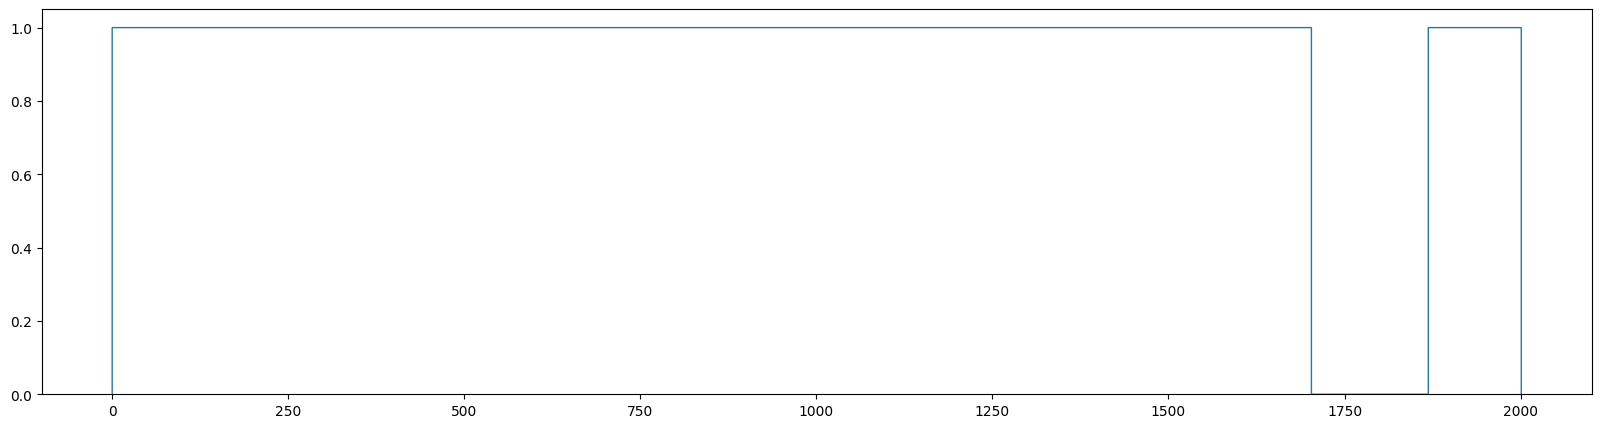

In [134]:
import matplotlib.pyplot as plt
values = [i[1] for i in system_status.B_t]
plt.figure(figsize=(20,5))
plt.stairs(values, label="B_t", fill=False)


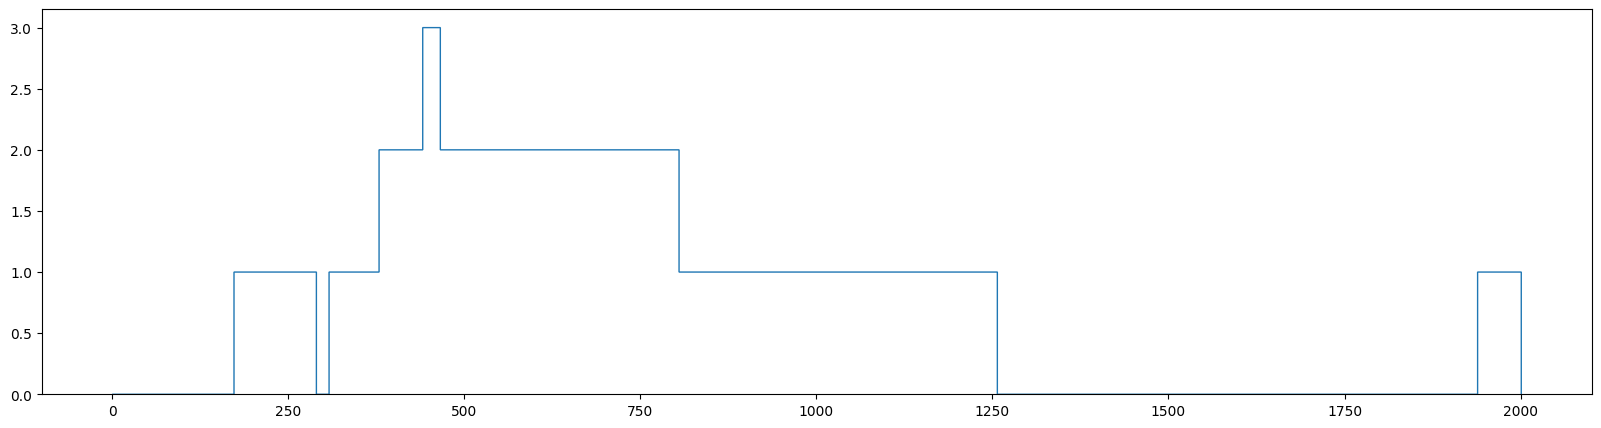

In [135]:
values = [i[1] for i in system_status.Q_t]
plt.figure(figsize=(20,5))
plt.stairs(values, label="Q_t", fill=False)

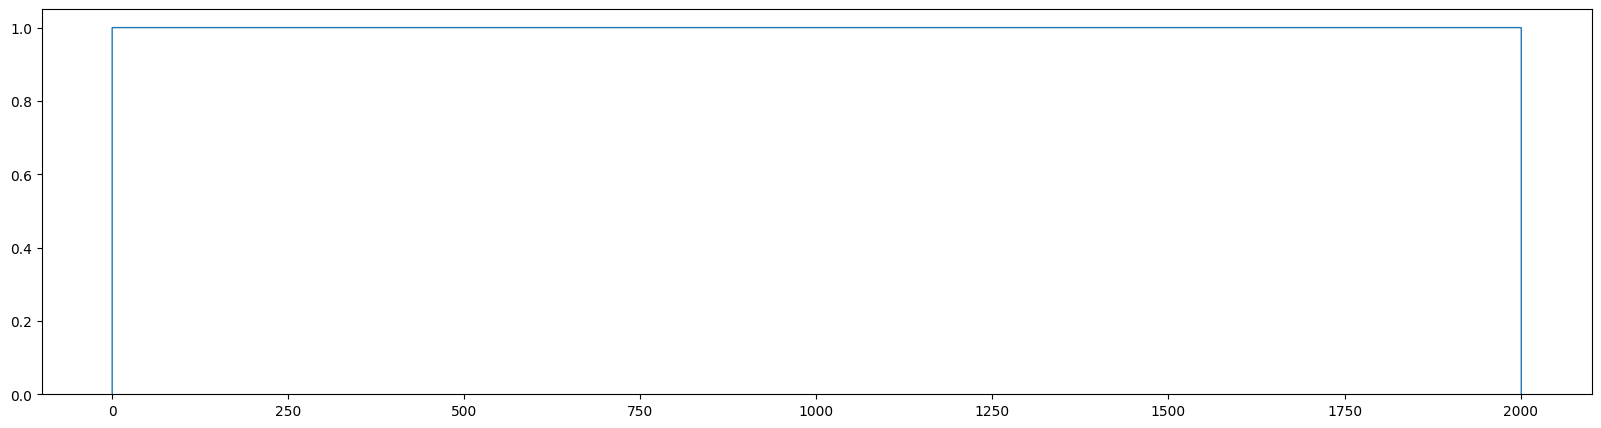

In [136]:
values = [i[1] for i in system_status2.B_t]
plt.figure(figsize=(20,5))
plt.stairs(values, label="B_t", fill=False)

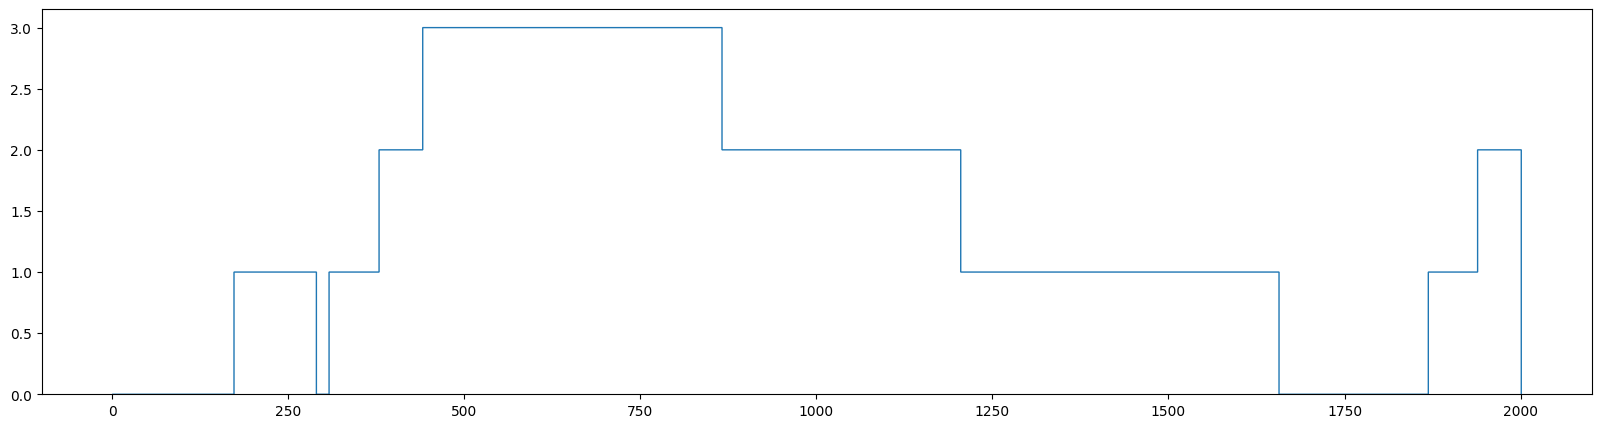

In [137]:
values = [i[1] for i in system_status2.Q_t]
plt.figure(figsize=(20,5))
plt.stairs(values, label="Q_t", fill=False)

In [128]:
@dataclass
class SimulationRecord:
    # entity: Entity
    # arrival_time: float
    # interarrival_time: float
    # service_time: float
    # departure_time: float
    # time_in_system: float
    # time_in_queue: float

    # def __repr__(self):
    #     return f"SimulationRecord(\
    pass